In [2]:
import keras
from keras import layers
import numpy as np

In [3]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [19]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    # epsilon = alpha
    #make random stddev, mean
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    # sample = mean(u) + alpha(epsilon) * standard diviation
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [20]:
# Create encoder (sub model)
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 64)           50240       ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 10)           650         ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 10)           650         ['dense_10[0][0]']               
                                                                                            

In [21]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [22]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [24]:
vae.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32)

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 145.8986
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 117.1903
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 110.5241
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 106.7675
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 104.6902
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 103.3296
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 102.3643
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 101.6524
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 101.1143
Epoch 10/100
1875/1875 [==============================] - 4s 2ms/step - loss: 100.6605
Epoch 11/100
1875/1875 [==============================] - 5s 3ms/step - loss: 100.3000
Epoch 12/100
1875/1875 [============================

In [26]:
x_decoded = vae.predict(x_train)

1875/1875 [==============================] - 2s 1ms/step


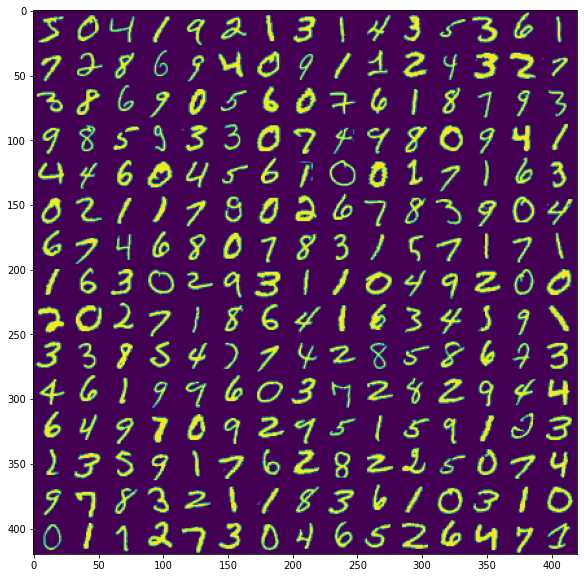

225


In [27]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
print (k)

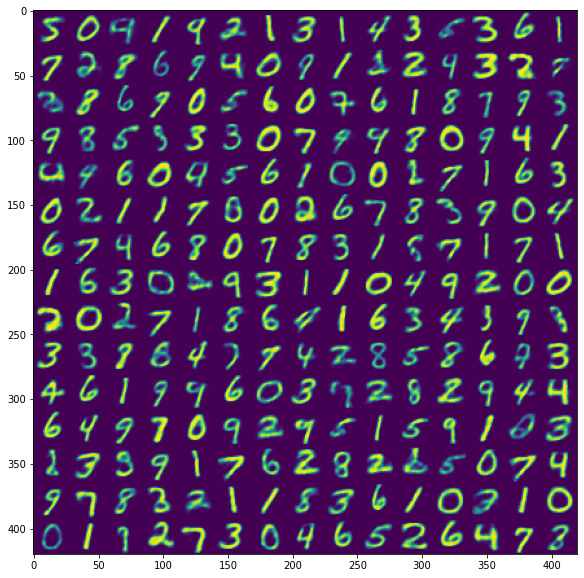

In [28]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()